# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19


Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torchvision.transforms.functional import normalize, resize, to_pil_image
from os.path import join
from sklearn.metrics import precision_score, f1_score, accuracy_score, roc_curve
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['normal', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test2classes'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test2classes', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 500) 
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test2classes', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset): 
    def __init__(self, image_dirs, transform): 
        
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names]) 
    
    def __getitem__(self, index): 
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) 
        image_name = self.images[class_name][index] 
        image_path = os.path.join(self.image_dirs[class_name], image_name) 
        image = Image.open(image_path).convert('RGB') 
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations and Augmentation

In [4]:
train_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(size=(224, 224)), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 

# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': f'{root_dir}/normal',
    'covid': f'{root_dir}/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
print (train_dataset)

In [ ]:
test_dirs = {
    'normal': f'{root_dir}/test2classes/normal',
 
    'covid': f'{root_dir}/test2classes/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

In [ ]:
batch_size = 6 
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test)) 

# Data Visualization

In [8]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0)) 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

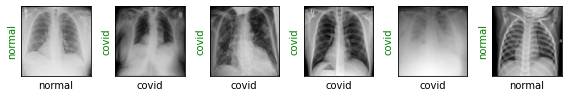

In [9]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

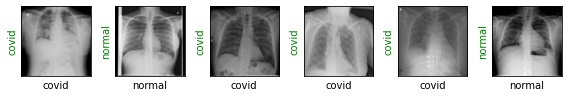

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# resnet18 is originally trained from scratch on a 1000 classes dataset. Since we are interested in classifying between 2 classes at each task, we have to change the last 
# fully connected layer number of outputs to 2. 

resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) 

In [13]:
def show_preds():
    resnet18.eval() 
    images, labels = next(iter(dl_test)) 
    outputs = resnet18(images) 

    _, preds = torch.max(outputs, 1) 
    show_images(images, labels, preds)

In [ ]:
show_preds()

# Fine-tuning of the pre-trained resnet18 model

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20) #cornice
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() 

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad() 
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels) 
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            
            if train_step % 20 == 0: 
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() 

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1) 
                    accuracy += sum((preds == labels).numpy()) 

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.10f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.10f}')
    print('Training complete..')

In [ ]:
%%time
train(epochs=100)

# Final Results

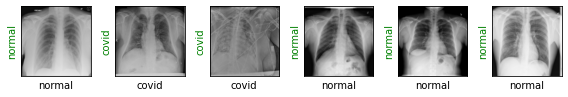

In [17]:
show_preds()

# Saving the Model

In [18]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')
model=torch.load ('covid_classifier.pt')

# Inference on a Single Image

In [21]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()



def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [22]:
image_path = 'COVID-19_Radiography_Dataset/Normal-2.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.9810141  0.01898589]
Predicted class index: 0
Predicted class name: normal


## CAM 

In [23]:
from torchcam.utils import overlay_mask
from torchcam.cams import SmoothGradCAMpp

In [ ]:
# Define your model
model=resnet18.eval()
model.fc=torch.nn.Linear(in_features=512, out_features=2)

# Set your CAM extractor
cam_extractor = SmoothGradCAMpp(model)

### Covid CAM 

In [ ]:
dirpath1= 'COVID-19_Radiography_Dataset/test/covid'

for filename in os.listdir(dirpath1)[0:3]:         
    target_path= join(dirpath1,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
  
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')
    

### Normal CAM 

In [ ]:
dirpath2='COVID-19_Radiography_Dataset/test/normal'

for filename in os.listdir(dirpath2)[0:3]:  
    target_path= join(dirpath2,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
   
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')
    


### Viral CAM 

In [ ]:
dirpath3='COVID-19_Radiography_Dataset/test/viral'
for filename in os.listdir(dirpath3)[0:3]:         
    target_path= join(dirpath3,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
   
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')
